In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

import cmcrameri.cm as cmc

from matplotlib import patches


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def moment_in_different_windows(window = None, window_prop = None):
    if window is None and window_prop is None:
        window_prop = 1

    diff = []
    moments = []

    romb = []
    simpson = []
    trapz = []

    simpson_short = []

    durations = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        db = combined[combined['scardec_name']==scardec_name]

        time_opt = []
        momentrate_opt = []

        time_moy = []
        momentrate_moy = []

        event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
        starts = [n for n, l in enumerate(event) if l.startswith('fctopt')]
        with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
            lines = f.read().splitlines()

        lines = lines[2:]
        for line in lines:
            split = line.split(' ')
            split = [s for s in split if s not in ['', ' ', '\n']]
            time_opt.append(float(split[0]))
            momentrate_opt.append(float(split[1]))

        momentrate_opt = np.array(momentrate_opt)

        not_zero = np.where(momentrate_opt > 0)[0]

        start = min(not_zero)
        end = max(not_zero)
        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        simpson.append(scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0]))
        trapz.append(scipy.integrate.trapezoid(momentrate_opt, dx = time_opt[1]-time_opt[0]))
        moments.append(db['moment'].values[0])

        if window_prop is None: #using static time window
            end_window = int((end-start)*(window/duration))
        else: #based on proportion of duration
            end_window = int((end-start)*window_prop)

        simpson_short.append(scipy.integrate.simpson(momentrate_opt[start:start + end_window], dx = time_opt[1]-time_opt[0]))
    return moments, simpson, simpson_short, trapz, durations

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [267]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [322]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [323]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    plt.close()

In [324]:
def plot_hist_figures_all(proportions_list, all_root_times, all_durations):
    for root_times, durations, proportion in zip(all_root_times, all_durations, proportions_list):
        root_times = np.array(root_times)
        durations = np.array(durations)

        plt.hist(root_times/durations, bins = 100, label = proportion, alpha = 0.5)

        plt.ylabel('Frequency')
        plt.xlabel(f'proportion of duration to release proportion of moment')

        plt.legend()
        plt.xlim(0, 1)

    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/combined_histogram_fraction_of_duration_for_percent_moment.png')
    plt.close()

In [325]:
proportions_list = [0.1, 0.3, 0.5]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

for proportion in proportions_list:
    print(proportion)
    durations = []
    root_times = []
    relative_root_times = []

    diff = []
    moments = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        #print(scardec_name)
        momentrate_opt, time_opt, db = get_stf(scardec_name)

        not_zero = np.where(momentrate_opt > 0)[0]

        dx = time_opt[1]-time_opt[0]

        start = min(not_zero)
        end = max(not_zero)
        points_before_zero = abs(min(time_opt)/dx)

        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        start_time = time_opt[start]
        end_time = time_opt[end]

        total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
        moments.append(total_moment)
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))
        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        root_times.append(root_time)
        relative_root_times.append(root_time-start_time)

        if root_time-start_time > duration:
            print('root time greater than duration, proportion:', proportion)
            print(scardec_name)

    plot_scatter_figures(proportion, relative_root_times, moments, durations)
    plot_hist_figures(proportion, relative_root_times, durations)

    all_durations.append(durations)
    all_root_times.append(root_times)
    all_moments.append(moments)
    all_relative_root_times.append(relative_root_times)

plot_hist_figures_all(proportions_list, all_relative_root_times, all_durations)

0.1
0.3
0.5


In [312]:
count = 0
for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    if scardec_name == 'FCTs_20220405_014408_NORTHERN_MOLUCCA_SEA':
        print(count)
    count += 1

2187


In [313]:
os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec')[2187]

'FCTs_20220405_014408_NORTHERN_MOLUCCA_SEA'

In [318]:
proportion = 0.5
print(proportion)
durations = []
root_times = []
relative_root_time = []

diff = []
moments = []

scardec_name = os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec')[2187]
#print(scardec_name)
momentrate_opt, time_opt, db = get_stf(scardec_name)

not_zero = np.where(momentrate_opt > 0)[0]

dx = time_opt[1]-time_opt[0]

start = min(not_zero)
end = max(not_zero)
points_before_zero = abs(min(time_opt)/dx)

duration = time_opt[end] - time_opt[start]
durations.append(duration)

start_time = time_opt[start]
end_time = time_opt[end]

total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
moments.append(total_moment)
root, r = scipy.optimize.bisect(f3,
                                start_time+dx,
                                end_time,
                                rtol = 1e-6,
                                full_output = True,
                                args = (total_moment,
                                        time_opt,
                                        momentrate_opt,
                                        start,
                                        points_before_zero,
                                        proportion,))
root_idx = np.floor(root/dx)
root_time = root_idx*dx
root_times.append(root_time)
relative_root_time.append(root_time - start_time)

if root_time-start_time > duration:
    print('root time greater than duration, proportion:', proportion)
    print(scardec_name)


0.5


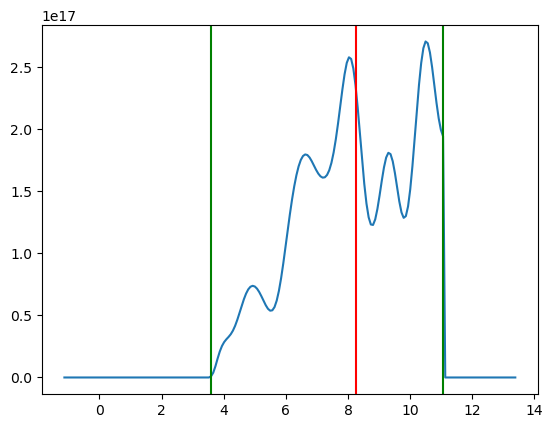

In [319]:
plt.plot(time_opt, momentrate_opt)
plt.axvline(x = root_time, color = 'red')
plt.axvline(x = time_opt[end], color = 'green')
plt.axvline(x = time_opt[start], color = 'green')